In [1]:
import os
import copy
import time
import random
import logging
import argparse
from io import BytesIO
from pathlib import Path

# Scientific/math  imports
import numpy as np
from scipy import ndimage

# Deep learning 
import torch
import torch.nn as nn
import tensorflow as tf
from torch import optim
from torch.optim import Adam
from tensorflow.keras.models import load_model
from torch.utils.data import Dataset, DataLoader

# Computer vision 
from PIL import Image
import torchvision.transforms as T
from torchvision.utils import make_grid

# Visualization
import matplotlib.pyplot as plt

# monitoring
import mlflow
from tqdm import tqdm
import mlflow.tensorflow
from torch.utils.tensorboard import SummaryWriter

2024-12-07 04:59:11.493972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 04:59:11.660175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 04:59:11.722162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 04:59:11.738510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 04:59:11.850682: I tensorflow/core/platform/cpu_feature_guar

Base Model

In [2]:
#class in PyTorch, making it a neural network module
class FSRCNN(nn.Module):
#Initialization
    def __init__(self, scale_factor):

        super(FSRCNN, self).__init__()
        self.scale_factor = scale_factor

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 56, kernel_size=5, padding=2),
            nn.PReLU()
        )
        self.shrinking = nn.Sequential(
            nn.Conv2d(56, 12, kernel_size=1),
            nn.PReLU()
        )
        self.non_linear_mapping = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU()
        )
        self.expanding = nn.Sequential(
            nn.Conv2d(12, 56, kernel_size=1),
            nn.PReLU()
        )
        self.deconvolution = nn.ConvTranspose2d(56, 3, kernel_size=9, 
                                                stride=scale_factor, padding=4, 
                                                output_padding=scale_factor-1)

#Foward Pass
    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrinking(x)
        x = self.non_linear_mapping(x)
        x = self.expanding(x)
        x = self.deconvolution(x)
        return x


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, PReLU, Conv2DTranspose, Input

def KFSRCNN(scale_factor, input_shape):
    # Input layer
    inputs = Input(shape=input_shape)  # Input shape is (height, width, channels)

    # Feature extraction
    x = Conv2D(56, kernel_size=5, padding='same')(inputs)
    x = PReLU()(x)

    # Shrinking
    x = Conv2D(12, kernel_size=1, padding='same')(x)
    x = PReLU()(x)

    # Non-linear mapping
    for _ in range(5):  # 5 Conv2D layers with 12 filters
        x = Conv2D(12, kernel_size=3, padding='same')(x)
        x = PReLU()(x)

    # Expanding
    x = Conv2D(56, kernel_size=1, padding='same')(x)
    x = PReLU()(x)

    # Deconvolution
    x = Conv2DTranspose(3, kernel_size=9, strides=scale_factor, padding='same',
                         output_padding=scale_factor - 1)(x)

    # Model definition
    model = tf.keras.Model(inputs, x, name="FSRCNN")
    return model

# Dataloader / Preprocessing
This section creates a custom dataset class specifically for the `DIV2K` dataset used in super-resolution tasks.     
It loads HR images, resizes them to the desired dimensions, creates corresponding LR images by downscaling, applies optional transformations,     
and returns both images as tensors suitable for training or evaluating a super-resolution model.


In [4]:
#This section makes it a custom dataset class that can be used with PyTorch's data loaders for training or evaluating models.
class DIV2KDataset(Dataset):
    def __init__(self, img_dir, scale_factor, desired_height, desired_width):
        super(DIV2KDataset, self).__init__()
        self.img_dir = img_dir
        self.scale_factor = scale_factor
        self.desired_height = desired_height
        self.desired_width = desired_width
        self.img_list = os.listdir(self.img_dir)
        self.lr_height = desired_height // scale_factor
        self.lr_width = desired_width // scale_factor

#Initialization
    def load_image(self, filepath):
        """Load and resize HR image"""
        img_hr = Image.open(filepath).convert('RGB')  # Ensure RGB
        img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)
        return np.array(img_hr, dtype=np.float32) / 255.0  
    
    def generate_lr_image(self, hr_img):
        """Generate LR image by applying random degradation operations"""
        # Convert PIL Image to numpy array
        img_np = np.array(hr_img, dtype=np.uint8)  # Ensure valid data type


        # Randomly select degradation operations and their order
        degradations = random.sample([
            self.apply_blur,
            self.apply_noise,
            self.apply_jpeg_compression,
            self.apply_pixelation
        ], k=random.randint(1, 2))

        for degradation in degradations:
            img_np = degradation(img_np)

        # Ensure image is resized to LR dimensions
        lr_img = Image.fromarray(img_np)
        lr_img = lr_img.resize(
            (self.desired_width // self.scale_factor, self.desired_height // self.scale_factor),
            Image.BICUBIC
        )
       
        return lr_img
    
    def apply_blur(self, img_np):
        """Apply Gaussian blur"""
        sigma = random.uniform(1.0, 3.0)
        return ndimage.gaussian_filter(img_np, sigma=sigma)
    
    def apply_noise(self, img_np):
        """Add random Gaussian noise"""
        noise_level = random.uniform(5, 25)
        noise = np.random.normal(0, noise_level, img_np.shape)
        noisy_img = np.clip(img_np + noise, 0, 255)
        return noisy_img.astype(np.uint8)
    
    def apply_jpeg_compression(self, img_np):
        """Simulate JPEG compression artifacts"""
        img_pil = Image.fromarray(img_np)
        buffer = BytesIO()
        quality = random.randint(10, 50)
        img_pil.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        compressed_img = Image.open(buffer)
        return np.array(compressed_img)
    
    def apply_jpeg_compression(self, img_np):
        """Simulate JPEG compression artifacts"""
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
        
        # Check if dimensions are valid
        if img_np.ndim != 3 or img_np.shape[2] != 3:
            raise ValueError(f"Invalid image shape for JPEG compression: {img_np.shape}")
        
        img_pil = Image.fromarray(img_np)
        buffer = BytesIO()
        quality = random.randint(10, 50)
        img_pil.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        compressed_img = Image.open(buffer)
        return np.array(compressed_img)

    
    def apply_pixelation(self, img_np):
        """Apply pixelation effect"""
        img_pil = Image.fromarray(img_np)
        current_size = img_pil.size
        reduction_factor = random.randint(2, 4)
        small_size = (current_size[0] // reduction_factor,
                     current_size[1] // reduction_factor)
        pixelated = img_pil.resize(small_size, Image.NEAREST).resize(
            current_size, Image.NEAREST)
        return np.array(pixelated)

    def convert_to_rgb(self, gray_img):
        """Convert grayscale image to RGB by repeating channels"""
        return Image.merge('RGB', (gray_img, gray_img, gray_img))

    def __getitem__(self, index):
        # Load image and convert to grayscale
        # Most of the original training images appear to be on greyscale. 
        img_hr = Image.open(os.path.join(self.img_dir, self.img_list[index]))

        # Resize HR image to desired size
        img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)
        
        # Generate LR image through degradation process
        img_lr = self.generate_lr_image(img_hr)
        
        # Convert  images back to RGB by repeating the grayscale channel
        # img_hr = self.convert_to_rgb(img_hr)
        # img_lr = self.convert_to_rgb(img_lr)

        transform = T.Compose([
            T.ToTensor(),
        ])

        img_hr = transform(img_hr)  # Will now be [3, H, W]
        img_lr = transform(img_lr)  # Will now be [3, H/scale, W/scale]

        return img_hr, img_lr
   
    def preprocess(self, index):
        filepath = os.path.join(self.img_dir, self.img_list[index])
        hr_img = self.load_image(filepath)
        lr_img = self.generate_lr_image(hr_img)
        return lr_img, hr_img

    def to_tf_dataset(self, batch_size=16, shuffle=True, cache=True):
        """Convert to TensorFlow Dataset by leveraging existing PyTorch methods"""
        def generator():
            indices = list(range(len(self)))
            if shuffle:
                random.shuffle(indices)
            
            for idx in indices:
                hr, lr = self.__getitem__(idx)
                # Convert PyTorch tensors to numpy arrays
                hr_np = hr.numpy()
                lr_np = lr.numpy()
                yield lr_np, hr_np  # TF convention is (input, target)
        
        # Create dataset from generator
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(3, self.lr_height, self.lr_width), dtype=tf.float32),
                tf.TensorSpec(shape=(3, self.desired_height, self.desired_width), dtype=tf.float32)
            )
        )
        
        # Convert from PyTorch's channel-first to TF's channel-last format
        dataset = dataset.map(
            lambda lr, hr: (
                tf.transpose(lr, [1, 2, 0]),
                tf.transpose(hr, [1, 2, 0])
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        if cache:
            dataset = dataset.cache()
        
        # Batch and prefetch
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        input_shape = (self.lr_height, self.lr_width, 3)
        return dataset, input_shape

    
    def __len__(self):
        return len(self.img_list)

I made several updates to improve the training class. First, I added support for both PyTorch and Keras models by introducing a `model_architecture` parameter,         
which defaults to 'torch', allowing flexibility to handle both frameworks. Next, I added a `save_checkpoint` method to save model checkpoints, using `.pt` files for PyTorch and `.h5` files for Keras.          
Similarly, I implemented a `load_checkpoint` method to load saved model states for both architectures, making it possible to resume training. Early stopping was also added,            
with an `early_stopping_patience` parameter to stop training if there’s no improvement after a set number of epochs. Finally, I created separate training and validation           
methods for PyTorch and Keras—`train_epoch_torch`, `train_epoch_keras`, `validate_torch`, and `validate_keras`—to handle architecture-specific logic.          

In [5]:
class FSRCNNTrainer:
    def __init__(
        self,
        model,
        model_architecture='torch',  # 'torch' or 'keras'
        criterion=None,
        optimizer=None,
        train_loader=None,
        val_loader=None,
        n_epochs=100,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        save_dir="checkpoints",
        exp_name="FSRCNN_Experiment"
    ):
        self.model_architecture = model_architecture.lower()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_epochs = n_epochs
        self.device = device
        
        # Setup directories
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)
        self.log_dir = self.save_dir / "/phoenix/tensorboard/"
        self.log_dir.mkdir(exist_ok=True)
        
        # Initialize trackers and loggers
        self.tb_writer = SummaryWriter(self.log_dir)
        self.best_metric = float('inf')
        self.best_epoch = -1
        self.run_name = exp_name
        self.early_stopping_patience = 10
        self.early_stopping_counter = 0
        
        # Keras specific setup
        if self.model_architecture == 'keras':
            self.keras_setup()
            
        # Setup logging
        self.setup_logging()
        
    def keras_setup(self):
        """Setup specific configurations for Keras model"""
        if self.criterion is None:
            self.criterion = tf.keras.losses.MeanSquaredError()
        if self.optimizer is None:
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            
        # Compile the model if it's not already compiled
        if not self.model.optimizer:
            self.model.compile(
                optimizer=self.optimizer,
                loss=self.criterion,
                metrics=['mse', self.calculate_psnr]
            )
    
    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(self.save_dir / 'training.log'),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)
        
    def save_checkpoint(self, epoch, is_best=False):
        """Save model checkpoint based on architecture"""
        if self.model_architecture == 'torch':
            # Save PyTorch model
            if is_best:
                best_model_path = self.save_dir / 'best_model.pt'
                torch.save(self.model.state_dict(), best_model_path)
                self.logger.info(f'Saved new best PyTorch model at epoch {epoch}')
            
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'best_metric': self.best_metric,
                'best_epoch': self.best_epoch
            }
            checkpoint_path = self.save_dir / f'checkpoint_epoch_{epoch}.pt'
            torch.save(checkpoint, checkpoint_path)
            
        else:  # Keras model
            if is_best:
                best_model_path = self.save_dir / 'best_model.h5'
                self.model.save(best_model_path)
                self.logger.info(f'Saved new best Keras model at epoch {epoch}')
            
            checkpoint_path = self.save_dir / f'checkpoint_epoch_{epoch}.h5'
            self.model.save(checkpoint_path)
    
    def load_checkpoint(self, checkpoint_path):
        """Load checkpoint based on architecture"""
        if self.model_architecture == 'torch':
            checkpoint = torch.load(checkpoint_path)
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                self.model.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                self.best_metric = checkpoint['best_metric']
                self.best_epoch = checkpoint['best_epoch']
                return checkpoint['epoch']
            else:
                self.model.load_state_dict(checkpoint)
                return None
        else:  # Keras model
            self.model = tf.keras.models.load_model(
                checkpoint_path,
                custom_objects={'calculate_psnr': self.calculate_psnr}
            )
            return None
    
    @staticmethod
    def calculate_psnr(y_true, y_pred):
        """Calculate PSNR metric for both PyTorch and Keras"""
        if isinstance(y_true, torch.Tensor):
            mse = torch.mean((y_true - y_pred) ** 2)
            return 20 * torch.log10(1.0 / torch.sqrt(mse))
        else:  # Tensorflow tensors
            return tf.image.psnr(y_true, y_pred, max_val=1.0)
    
    def train_epoch_torch(self, epoch):
        """Training epoch for PyTorch model"""
        self.model.train()
        running_loss = 0.0
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch}/{self.n_epochs}')
        
        for i, (hr, lr) in enumerate(pbar):
            hr = hr.to(self.device)
            lr = lr.to(self.device)
            
            self.optimizer.zero_grad()
            
            try:
                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
            except RuntimeError as e:
                self.logger.error(f'Error in training batch {i}: {str(e)}')
                continue
                
        return running_loss / len(self.train_loader)
    
    def train_epoch_keras(self, epoch):
        """Training epoch for Keras model"""
        history = self.model.fit(
            self.train_loader,
            epochs=1,
            verbose=1,
            validation_data=self.val_loader
        )
        return history.history['loss'][0]
    
    def validate_torch(self):
        """Validation for PyTorch model"""
        self.model.eval()
        metrics_sum = {'loss': 0.0, 'psnr': 0.0}
        
        with torch.no_grad():
            for hr, lr in tqdm(self.val_loader, desc='Validating'):
                hr = hr.to(self.device)
                lr = lr.to(self.device)
                
                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)
                psnr = self.calculate_psnr(hr, outputs)
                
                metrics_sum['loss'] += loss.item()
                metrics_sum['psnr'] += psnr.item()
        
        n_batches = len(self.val_loader)
        return {k: v / n_batches for k, v in metrics_sum.items()}
    
    def validate_keras(self):
        """Validation for Keras model"""
        results = self.model.evaluate(self.val_loader, verbose=1)
        return {
            'loss': results[0],
            'psnr': results[2]  # Assuming PSNR is the third metric
        }
    
    def log_images_to_tensorboard(self, epoch):
        """Log images to tensorboard based on model architecture"""
        if self.model_architecture == 'torch':
            self.model.eval()
            with torch.no_grad():
                hr, lr = next(iter(self.val_loader))
                hr = hr.to(self.device)
                lr = lr.to(self.device)
                outputs = self.model(lr)
                
                grid_hr = make_grid(hr, nrow=1, normalize=True)
                grid_lr = make_grid(lr, nrow=1, normalize=True)
                grid_sr = make_grid(outputs, nrow=1, normalize=True)
                
                self.tb_writer.add_image(f'Original/Epoch_{epoch + 1}', grid_hr, epoch)
                self.tb_writer.add_image(f'Low Resolution/Epoch_{epoch + 1}', grid_lr, epoch)
                self.tb_writer.add_image(f'Super-Resolved/Epoch_{epoch + 1}', grid_sr, epoch)
        else:
            # Keras
            for images in self.val_loader.take(1):
                hr, lr = images
                outputs = self.model.predict(lr)
                
                # Convert to numpy and reshape if needed
                hr = hr.numpy()
                lr = lr.numpy()
                
                # Log images (assuming they're in the correct format)
                self.tb_writer.add_images('Original', hr, epoch)
                self.tb_writer.add_images('Low Resolution', lr, epoch)
                self.tb_writer.add_images('Super-Resolved', outputs, epoch)
    
    def train(self):
        """Main training loop that works for both architectures"""
        start_time = time.time()
        self.logger.info(f"Starting training with {self.n_epochs} epochs")
        
        with mlflow.start_run(run_name=self.run_name) as run:
            for epoch in range(self.n_epochs):
                # Train epoch based on architecture
                if self.model_architecture == 'torch':
                    train_loss = self.train_epoch_torch(epoch)
                    val_metrics = self.validate_torch()
                else:
                    train_loss = self.train_epoch_keras(epoch)
                    val_metrics = self.validate_keras()
                
                # Log metrics
                self.tb_writer.add_scalar('Loss/train', train_loss, epoch)
                self.tb_writer.add_scalar('Loss/val', val_metrics['loss'], epoch)
                self.tb_writer.add_scalar('PSNR/val', val_metrics['psnr'], epoch)
                
                # Log to MLflow
                mlflow.log_metrics({
                    'train_loss': train_loss,
                    'val_loss': val_metrics['loss'],
                    'val_psnr': val_metrics['psnr'],
                }, step=epoch)
                
                # Save visualizations every 10 epochs
                if (epoch + 1) % 10 == 0:
                    self.log_images_to_tensorboard(epoch)
                
                # Check if this is the best model
                if val_metrics['loss'] < self.best_metric:
                    self.best_metric = val_metrics['loss']
                    self.best_epoch = epoch
                    self.save_checkpoint(epoch, is_best=True)
                    self.early_stopping_counter = 0
                else:
                    self.early_stopping_counter += 1
                
                # Regular checkpoint saving
                if (epoch + 1) % 10 == 0:
                    self.save_checkpoint(epoch)
                
                # Early stopping check
                if self.early_stopping_counter >= self.early_stopping_patience:
                    self.logger.info(f'Early stopping triggered at epoch {epoch}')
                    break
                
                self.logger.info(
                    f"Epoch {epoch + 1}/{self.n_epochs} - "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Val Loss: {val_metrics['loss']:.4f}, "
                    f"Val PSNR: {val_metrics['psnr']:.2f}"
                )
            
            # Log model to MLflow
            if self.model_architecture == 'torch':
                mlflow.pytorch.log_model(self.model, "fsrcnn")
            else:
                mlflow.keras.log_model(self.model, "fsrcnn")
            
            mlflow.register_model(
                model_uri=f"runs:/{run.info.run_id}/fsrcnn",
                name="fsrcnn"
            )
        
        training_time = time.time() - start_time
        self.logger.info(f'Total training time: {training_time:.2f} seconds')
        self.tb_writer.close()


experiments = client.search_experiments()
for experiment in experiments:
    print(experiment.name)
    print(experiment.experiment_id)

The FSRCNNResolutionModel is a class designed to manage loading and handling of the models, data loaders and visualization of the results.      
Specifically it handles the process of loading pre-trained models that use the FSRCNN (Fast Super-Resolution Convolutional Neural Network)      
architecture on both Pytorch and Keras.    
This way making it more modular and self-contained that it can be reused and makes it easy to accommodate changes in the FSRCNN model or new requirements.

In [6]:
class FSRCNNResolutionModel:
    def __init__(self, config=None, model_architecture='torch'):
        """
        Initialize the Super Resolution model with configurations
        Args:
            config: Configuration object
            model_architecture: 'torch' or 'keras'
        """
        self.config = config or self._default_config()
        self.model_architecture = model_architecture
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.input_shape = None
        
        # Initialize model based on architecture
        if self.model_architecture == 'torch':
            self.model = FSRCNN(self.config.scale)
            self.model.to(self.device)
            self.criterion = nn.MSELoss()
            self.optimizer = Adam(self.model.parameters(), lr=1e-4)
        elif self.model_architecture == 'keras':
            self.model = None  # Will be set by load_keras_model
            self.criterion = 'mse'
            self.optimizer = 'adam'
        else:
            raise ValueError(f"Unsupported model architecture: {model_architecture}")
        
        # Initialize dataloaders
        self._setup_dataloaders()

    def _default_config(self):
        """
        Default configuration if none is provided
        """
        class Config:
            train_dir = 'train/'
            val_dir = 'valid/' 
            scale = 4
            batch_size = 4
            epochs = 300
        return Config()

    def _setup_dataloaders(self):
        """
        Set up training and validation dataloaders
        """
        # Load datasets
        train_dataset = DIV2KDataset(
            self.config.train_dir, 
            self.config.scale, 
            1020, 
            2040
        )
        
        val_dataset = DIV2KDataset(
            self.config.val_dir, 
            self.config.scale, 
            1020, 
            2040
        )
        
        if self.model_architecture == 'torch':
            # Create PyTorch dataloaders
            self.train_loader = DataLoader(
                train_dataset, 
                batch_size=self.config.batch_size, 
                shuffle=True
            )
            self.val_loader = DataLoader(
                val_dataset, 
                batch_size=self.config.batch_size, 
                shuffle=True
            )
        else:
            # Create TensorFlow datasets
            self.train_loader, self.input_shape = train_dataset.to_tf_dataset(
                batch_size=self.config.batch_size,
                shuffle=True
            )
            self.val_loader, _ = val_dataset.to_tf_dataset(
                batch_size=self.config.batch_size,
                shuffle=False
            )

    def load_model(self, model_path, build_model_function = None, **kwargs):
        """
        Load a pretrained model
        """

        if self.model_architecture == 'torch':
             if os.path.exists(model_path):
                self.model.load_state_dict(torch.load(model_path))
                self.model.eval()
             else:
                print(f"No saved model found at: {model_path}. Creating a new model.")
                self.model = build_model_function(**kwargs)
        else:
            self.model = tf.keras.models.load_model(model_path)

    def load_keras_model(self, model_path, build_model_function, **kwargs):
        """
        Loads a Keras model from a file or creates a new instance if no saved model exists.
        """
        if self.model_architecture != 'keras':
            raise ValueError("This method is only for Keras architecture")
            
        if os.path.exists(model_path):
            print(f"Loading model from: {model_path}")
            self.model = tf.keras.models.load_model(model_path)
        else:
            print(f"No saved model found at: {model_path}. Creating a new model.")
            self.model = build_model_function(**kwargs)
        
        # Compile the model
        self.model.compile(
            optimizer=self.optimizer,
            loss=self.criterion,
            metrics=['mse', 'mae']
        )
        return self.model

    def train(self, n_epochs, model_architecture=None, criterion=None, optimizer=None):
        """
        Train the model using FSRCNNTrainer
        """
        model_architecture = model_architecture or self.model_architecture
        criterion = criterion or self.criterion
        optimizer = optimizer or self.optimizer
        
        trainer = FSRCNNTrainer(
            model=self.model,
            model_architecture=model_architecture,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=self.train_loader,
            val_loader=self.val_loader,
            n_epochs=n_epochs,
            device=self.device
        )
        return trainer.train()

    def predict(self, x):
        """
        Make a prediction on a single input
        """
        if self.model_architecture == 'torch':
            x = x.to(self.device)
            with torch.no_grad():
                pred = self.model(x)
            return pred.cpu()
        else:
            return self.model.predict(x)

    def visualize_results(self, original, fed_image,  prediction):

        if self.model_architecture == 'torch':
            fed_image = fed_image.numpy().transpose(1, 2, 0)  # Convert CHW -> HWC
            original = original.numpy().transpose(1, 2, 0)    # Convert CHW -> HWC
            prediction = prediction.detach().numpy().transpose(1, 2, 0)  # Convert CHW -> HWC
        else:
            fed_image = fed_image.numpy()  # Keras tensors are already HWC
            original = original.numpy()
            prediction = prediction.numpy()
        
        # Reconstruct the predicted high-resolution image
        # reconstructed = fed_image + prediction  # Add the residual to the fed image
        
        # Visualize the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(fed_image)
        axes[0].set_title('Fed Image (Input)')
        axes[0].axis('off')
        
        axes[1].imshow(prediction)
        axes[1].set_title('Reconstructed High Resolution')
        axes[1].axis('off')
        
        axes[2].imshow(original)
        axes[2].set_title('Original High Resolution')
        axes[2].axis('off')
        
        plt.show()

    def process_sample(self):
        """
        Process and visualize a sample from the validation set
        """
        if self.model_architecture == 'torch':
            x_batch, y_batch = next(iter(self.val_loader))
            y, x = x_batch[0], y_batch[0]
        else:
            # For Keras model
            for x_batch, y_batch in self.val_loader.take(1):
                # Get first sample from batch
                y, x = y_batch[0], x_batch[0]
                
                # Add batch dimension if needed
                if len(x.shape) == 3:
                    x = tf.expand_dims(x, 0)
                
                expected_shape = (None, 255, 510, 3)  # feed shape from data (lr)
                if x.shape[1:] != expected_shape[1:]:
                    # Reshape or resize if necessary
                    x = tf.image.resize(x, (255, 510))
                    if len(x.shape) == 3:
                        x = tf.expand_dims(x, 0)
                break
            
        try:
            pred = self.predict(x)
            
            print('Input shape:', x.shape)
            print('Prediction shape:', pred.shape)
            print('High Resolution shape:', y.shape)
            
            # Remove batch dimension for visualization
            if len(pred.shape) == 4:
                pred = pred[0]
            if len(y.shape) == 4:
                y = y[0]
                
            self.visualize_results(y, x, pred)
            
        except Exception as e:
            print(f"Error during processing: {str(e)}")
            print(f"Input tensor shape: {x.shape}")

    def save_model(self, path):
        """
        Save the model to disk
        """
        if self.model_architecture == 'torch':
            torch.save(self.model.state_dict(), path)
        else:
            self.model.save(path)

    
    def visualize_train_images(self, save_path=None):
        """
        Visualize a pair of images (HR and LR) from the training set
        Args:
            save_path (str, optional): Path to save the HR image
        """
        for imgs in self.train_loader:
            fig = plt.figure(figsize=(15, 10))

            # High Resolution Image
            img_hr = imgs[0][0].permute(1, 2, 0)
            fig.add_subplot(1, 2, 1)
            plt.imshow(img_hr)
            plt.title('High Resolution (Training)')
            print('Image HR shape:', img_hr.shape)

            # Low Resolution Image
            img_lr = imgs[1][0].permute(1, 2, 0)
            fig.add_subplot(1, 2, 2)
            plt.imshow(img_lr)
            plt.title('Low Resolution (Training)')
            print('Image LR shape:', img_lr.shape)

            # Save HR image if path is provided
            if save_path:
                # Convert tensor to PIL Image and save
                img_hr_pil = Image.fromarray((img_hr.numpy() * 255).astype('uint8'))
                img_hr_pil.save(save_path)

            plt.tight_layout()
            plt.show()
            break

    def visualize_val_images(self, save_path=None):
      
        for imgs in self.val_loader:
            fig = plt.figure(figsize=(15, 10))

            # High Resolution Image
            img_hr = imgs[0][0].permute(1, 2, 0)
            fig.add_subplot(1, 2, 1)
            plt.imshow(img_hr)
            plt.title('High Resolution (Validation)')
            if save_path:
                # Convert tensor to PIL Image and save
                img_hr_pil = Image.fromarray((img_hr.numpy() * 255).astype('uint8'))
                img_hr_pil.save(save_path)

            # Low Resolution Image
            img_lr = imgs[1][0].permute(1, 2, 0)
            fig.add_subplot(1, 2, 2)
            plt.imshow(img_lr)
            plt.title('Low Resolution (Validation)')

            plt.tight_layout()
            plt.show()
            break

    def visualize_keras_train_images(self, save_path=None):
        
        for imgs in self.train_loader:
            fig = plt.figure(figsize=(15, 10))

            # High Resolution Image
            # Ensure proper shape transformation and normalization
            img_hr = imgs[1][0]  # For high resolution
            
            if len(img_hr.shape) == 3: 
                if img_hr.shape[-1] != 3: 
                    img_hr = tf.transpose(img_hr, perm=[1, 2, 0])
            
            if tf.reduce_max(img_hr) > 1.0:
                img_hr = img_hr / 255.0
                
            fig.add_subplot(1, 2, 1)
            plt.imshow(img_hr.numpy())
            plt.title('High Resolution (Training)')
            print('Image HR shape:', img_hr.shape)

            # Low Resolution Image
            img_lr = imgs[0][0]
            if len(img_lr.shape) == 3: 
                if img_lr.shape[-1] != 3: 
                    img_lr = tf.transpose(img_lr, perm=[1, 2, 0])
            
            if tf.reduce_max(img_lr) > 1.0:
                img_lr = img_lr / 255.0
                
            fig.add_subplot(1, 2, 2)
            plt.imshow(img_lr.numpy())
            plt.title('Low Resolution (Training)')
            print('Image LR shape:', img_lr.shape)

            if save_path:
                img_hr_pil = Image.fromarray((img_hr.numpy() * 255).astype('uint8'))
                img_hr_pil.save(save_path)

            plt.tight_layout()
            plt.show()
            break

    def visualize_keras_val_images(self, save_path=None):
       
        for imgs in self.val_loader:
            fig = plt.figure(figsize=(15, 10))

            # High Resolution Image
            img_hr = imgs[1][0]
            if len(img_hr.shape) == 3:  
                if img_hr.shape[-1] != 3: 
                    img_hr = tf.transpose(img_hr, perm=[1, 2, 0])
            
            if tf.reduce_max(img_hr) > 1.0:
                img_hr = img_hr / 255.0
                
            fig.add_subplot(1, 2, 1)
            plt.imshow(img_hr.numpy())
            plt.title('High Resolution (Validation)')
            if save_path:
                img_hr_pil = Image.fromarray((img_hr.numpy() * 255).astype('uint8'))
                img_hr_pil.save(save_path)

            # Low Resolution Image
            img_lr = imgs[0][0]
            if len(img_lr.shape) == 3: 
                if img_lr.shape[-1] != 3: 
                    img_lr = tf.transpose(img_lr, perm=[1, 2, 0])
            
            if tf.reduce_max(img_lr) > 1.0:
                img_lr = img_lr / 255.0
                
            fig.add_subplot(1, 2, 2)
            plt.imshow(img_lr.numpy())
            plt.title('Low Resolution (Validation)')

            plt.tight_layout()
            plt.show()
            break

In [8]:
# Initialize with Keras architecture
model = FSRCNNResolutionModel(model_architecture='keras')

# Load or create Keras model
model.load_keras_model(
    model_path='fsrcnn_keras.h5',
    build_model_function=KFSRCNN,
    scale_factor=model.config.scale,
    input_shape =model.input_shape
)

# Train the model
model.train(n_epochs=1)

I0000 00:00:1733548087.778406    1137 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 05:08:07.786922: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-07 05:08:07,951 - INFO - Starting training with 1 epochs


No saved model found at: fsrcnn_keras.h5. Creating a new model.


MlflowException: Could not find experiment with ID 0

Image HR shape: (1020, 2040, 3)
Image LR shape: (255, 510, 3)


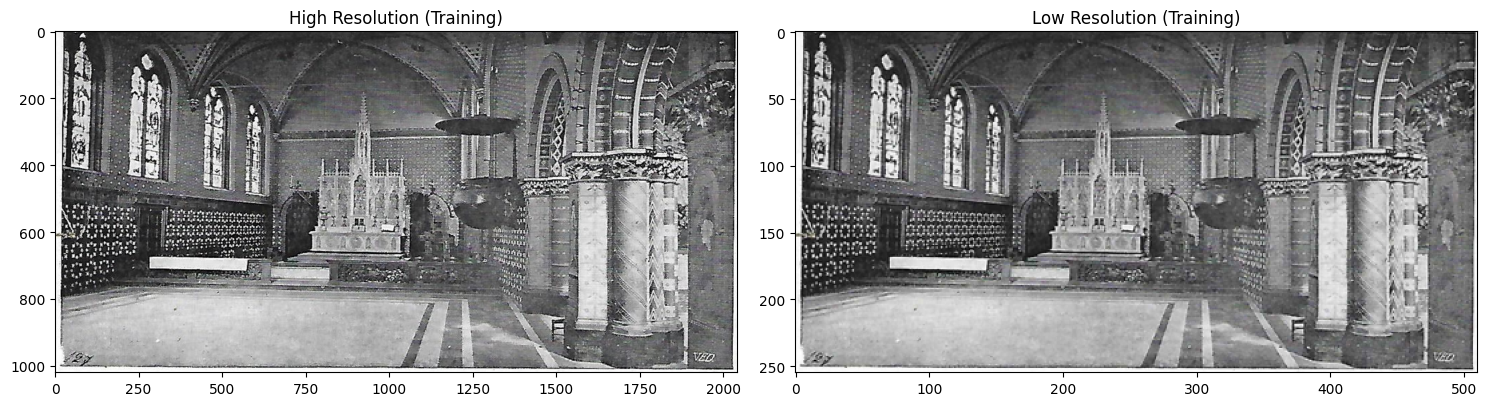

2024-12-07 05:08:17.469276: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


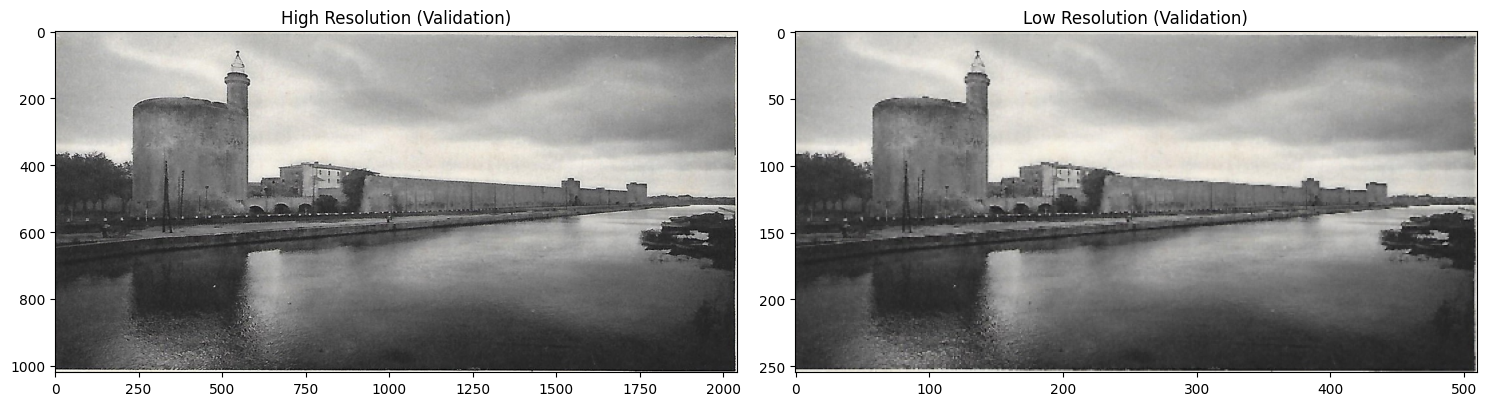

2024-12-07 05:08:18.697155: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Input shape: (1, 255, 510, 3)
Prediction shape: (1, 1020, 2040, 3)
High Resolution shape: (1020, 2040, 3)
Error during processing: 'numpy.ndarray' object has no attribute 'numpy'
Input tensor shape: (1, 255, 510, 3)


2024-12-07 05:08:19.188869: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:

# Visualize training and validation images
model.visualize_keras_train_images(save_path="keras_train_hr.png")
model.visualize_keras_val_images(save_path="keras_val_hr.png")

# Process and visualize a sample
model.process_sample()


I tried several changes to the model, including keeping the residue from the features layer and then reapplying it before the transpose. In theory, I want to preserve a part of the learned features and texture. This way, if the model encounters something like a faded building, it would be able to identify the curves and lines of the building, while the other part of the model focuses on the texture. The idea is that the model would correct the image much like the "fill" feature in Photoshop, where it fills in missing areas with the best match from what it’s learned.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FSRCNN(nn.Module):
    # Initialization
    def __init__(self, scale_factor):
        super(FSRCNN, self).__init__()
        self.scale_factor = scale_factor

        # Feature extraction layer
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 56, kernel_size=5, padding=2),
            nn.PReLU()
        )

        # Shrinking layer
        self.shrinking = nn.Sequential(
            nn.Conv2d(56, 12, kernel_size=1),
            nn.PReLU()
        )

        # Non-linear mapping
        self.non_linear_mapping = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU()
        )

        # Expanding layer
        self.expanding = nn.Sequential(
            nn.Conv2d(12, 56, kernel_size=1),
            nn.PReLU()
        )

        # Deconvolution layer
        self.deconvolution = nn.ConvTranspose2d(
            56, 3, kernel_size=9, stride=scale_factor, padding=4, 
            output_padding=scale_factor - 1
        )

    # Forward pass
    def forward(self, x):
        # Feature extraction (save residue)
        # Keep Features (Curves, shapes, etc)
        feature_residue = self.feature_extraction(x)

        # Shrinking
        x = self.shrinking(feature_residue)

        # Non-linear mapping
        x = self.non_linear_mapping(x)

        # Expanding
        x = self.expanding(x)

        # Reapply feature residue (addition)
        # Assumption is X = Texture gradients so we add back Original features
        x = x + feature_residue  # Fuse residue with transformed features

        # Deconvolution
        x = self.deconvolution(x)
        return x


In [11]:
# Initialize with Keras architecture
model = FSRCNNResolutionModel(model_architecture='torch')

# Load or create Keras model
model.load_model(
    model_path='fsrcnn_torch.pt',
    build_model_function=FSRCNN,
    scale_factor=model.config.scale,
)

# Train the model
model.train(n_epochs=10)

2024-12-07 05:08:27,367 - INFO - Starting training with 10 epochs


No saved model found at: fsrcnn_torch.pt. Creating a new model.


MlflowException: Could not find experiment with ID 0

Image HR shape: torch.Size([1020, 2040, 3])
Image LR shape: torch.Size([255, 510, 3])


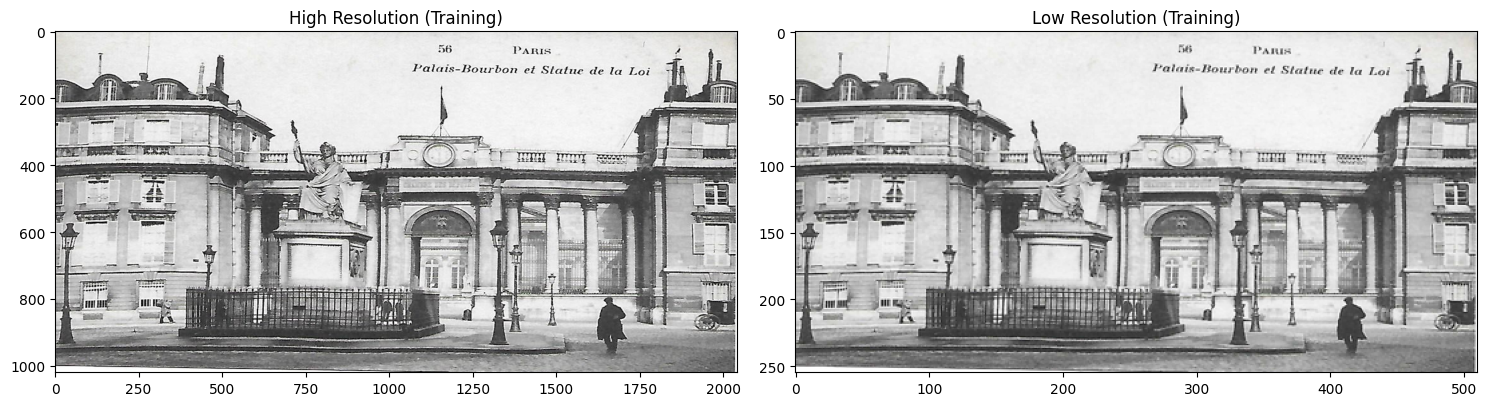

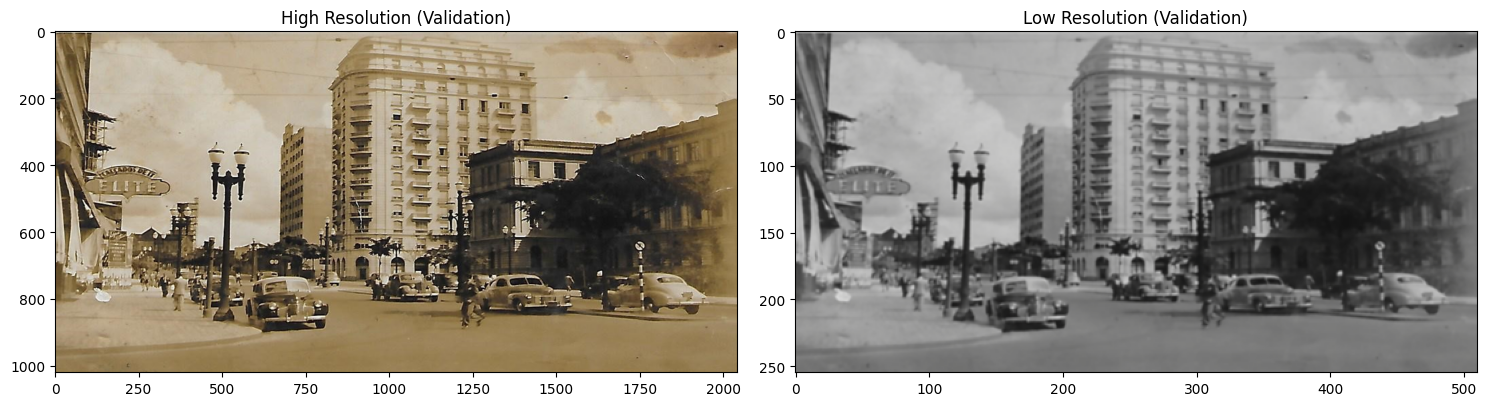

Error during processing: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input tensor shape: torch.Size([3, 255, 510])


In [12]:
model.visualize_train_images(save_path="train_hr.png")
model.visualize_val_images(save_path="val_hr.png")

# Process and visualize a sample
model.process_sample()

In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def upscale_image(image_path, model_path, output_path=None, device=None):
    """
    Upscale an image using the trained FSRCNN model.
    
    Args:
        image_path (str): Path to the input image
        model_path (str): Path to the trained model weights
        output_path (str, optional): Path to save the upscaled image
        device (str, optional): Device to run inference on ('cuda' or 'cpu')
    
    Returns:
        PIL.Image: Upscaled image
    """
    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load model exactly as in training
    model = FSRCNN(4)  # Using scale factor 4 as in your training code
    model.to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Load and prepare image
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert to tensor - matching the same preprocessing as training
    transform = transforms.ToTensor()
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Upscale
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert back to image
    output = output.squeeze(0).cpu().clamp(0, 1)
    upscaled_img = transforms.ToPILImage()(output)
    
    # Save if output path provided
    if output_path:
        upscaled_img.save(output_path)
        print(f"Saved upscaled image to: {output_path}")
    
    return upscaled_img

# Simple usage example
def upscale_folder(input_folder, output_folder, model_path):
    """
    Upscale all images in a folder.
    
    Args:
        input_folder (str): Folder containing input images
        output_folder (str): Folder to save upscaled images
        model_path (str): Path to the trained model weights
    """
    import os
    from pathlib import Path
    
    # Create output folder if it doesn't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    # Process each image
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, f'upscaled_{filename}')
            
            print(f"Processing {filename}...")
            upscale_image(input_path, model_path, output_path)

In [14]:

# Option 1: Quick one-off upscaling
upscale_image(
    image_path='train/Scan_0001.jpg',
    model_path='checkpoints/best_model.pt',
    output_path='high_res_image.jpg'
)

/tmp/ipykernel_1137/2015356450.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/best_model.pt'

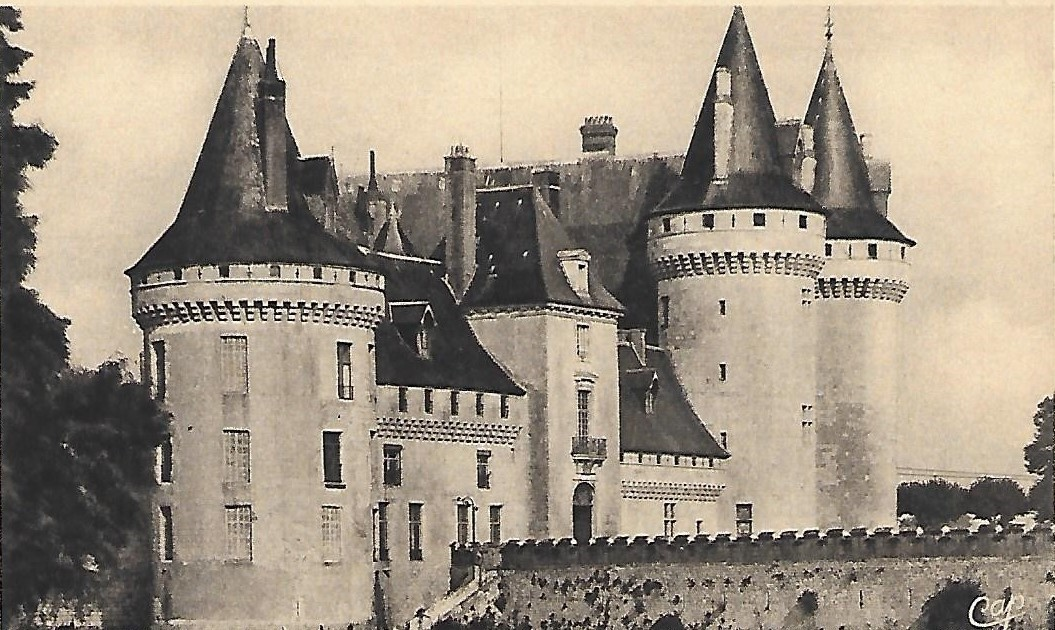

In [15]:
from IPython.display import Image, display

# Display the image
display(Image(filename='train/Scan_0001.jpg'))